In [19]:
import os
import json
import pandas as pd
import seaborn as sns
from torch.utils.data import DataLoader, TensorDataset
import torch
from torch import nn
import matplotlib.pyplot as plt
from tqdm import tqdm

100%|██████████| 21/21 [00:01<00:00, 12.96it/s]


<Axes: xlabel='fold', ylabel='mode-target_data_pct'>

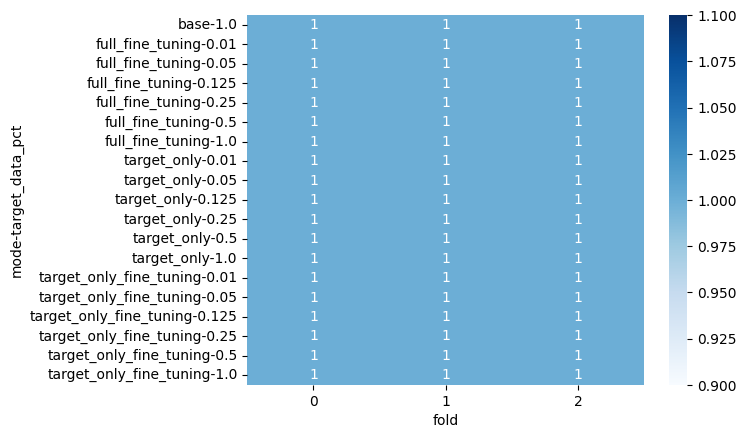

In [196]:
"""
This block plots performance from entire experiments directory for something like a hyperparameter sweep.
"""
import os
import json
import pandas as pd
import seaborn as sns
from torch.utils.data import DataLoader, TensorDataset
import torch
from torch import nn
import matplotlib.pyplot as plt
from tqdm import tqdm
from lib.models import TestModel
from lib.train_utils import compute_loss_and_f1,evaluate
from sklearn.metrics import classification_report

data = []

experiments_dir = f'./experiments'
device = 'cuda'

for experiment in tqdm(os.listdir(experiments_dir)):
    for run in os.listdir(f'{experiments_dir}/{experiment}'):
        if not os.path.exists(f'{experiments_dir}/{experiment}/{run}/metrics.json'):
            print(f'Skipping {experiments_dir}/{experiment}/{run} as no metrics.json')
            continue
        
        metrics = json.load(open(f'{experiments_dir}/{experiment}/{run}/metrics.json'))
        losses = json.load(open(f'{experiments_dir}/{experiment}/{run}/losses.json'))
        hyperparameters = json.load(open(f'{experiments_dir}/{experiment}/{run}/hyperparameters.json'))

        if experiment.startswith('base'):
            hyperparameters['mode'] = 'base'
            best_base_model_path = f'{experiments_dir}/{experiment}/{run}/best_base_model.pt'
            from lib.models import TestModel
            target_participant = hyperparameters['target_participant']
            data_path = hyperparameters['data_path']
            batch_size = hyperparameters['batch_size']
            criterion = nn.BCEWithLogitsLoss()
            target_test_dataset = TensorDataset(*torch.load(f'{data_path}/{target_participant}_test.pt'))
            target_testloader = DataLoader(target_test_dataset, batch_size=batch_size, shuffle=False)
            model = TestModel()
            model.load_state_dict(torch.load(best_base_model_path, map_location='cpu'))
            model.to(device)
            test_loss, test_f1 = compute_loss_and_f1(model, target_testloader, criterion, device=device)
            metrics['test_f1'] = test_f1
            metrics['test_loss'] = test_loss
        
        # TODO: compute absolute improvement for each finetune model, may need two consecutive loops

        data.append({
            **metrics,
            **hyperparameters,
            'experiment': experiment,
            'run': run
        })
df = pd.DataFrame(data)

def get_base_test_f1(row):
    if row['mode'] == 'base':
        return row['test_f1']
    else:
        base_row = df[df['experiment'] == row['base_experiment_prefix']]
        return base_row['test_f1'].iloc[0] if len(base_row) > 0 else None

df['base_test_f1'] = df.apply(get_base_test_f1, axis=1)
df['absolute_improvement'] = df['test_f1'] - df['base_test_f1']

combo_df = df.groupby(['mode', 'target_data_pct', 'batch_size', 'fold']).size().reset_index(name='count')
pivot_df = combo_df.pivot_table(values='count', 
                                index=['mode', 'target_data_pct'], 
                                columns=['fold'], 
                                fill_value=0)

sns.heatmap(pivot_df, annot=True, cmap='Blues')

<Axes: xlabel='fold', ylabel='absolute_improvement'>

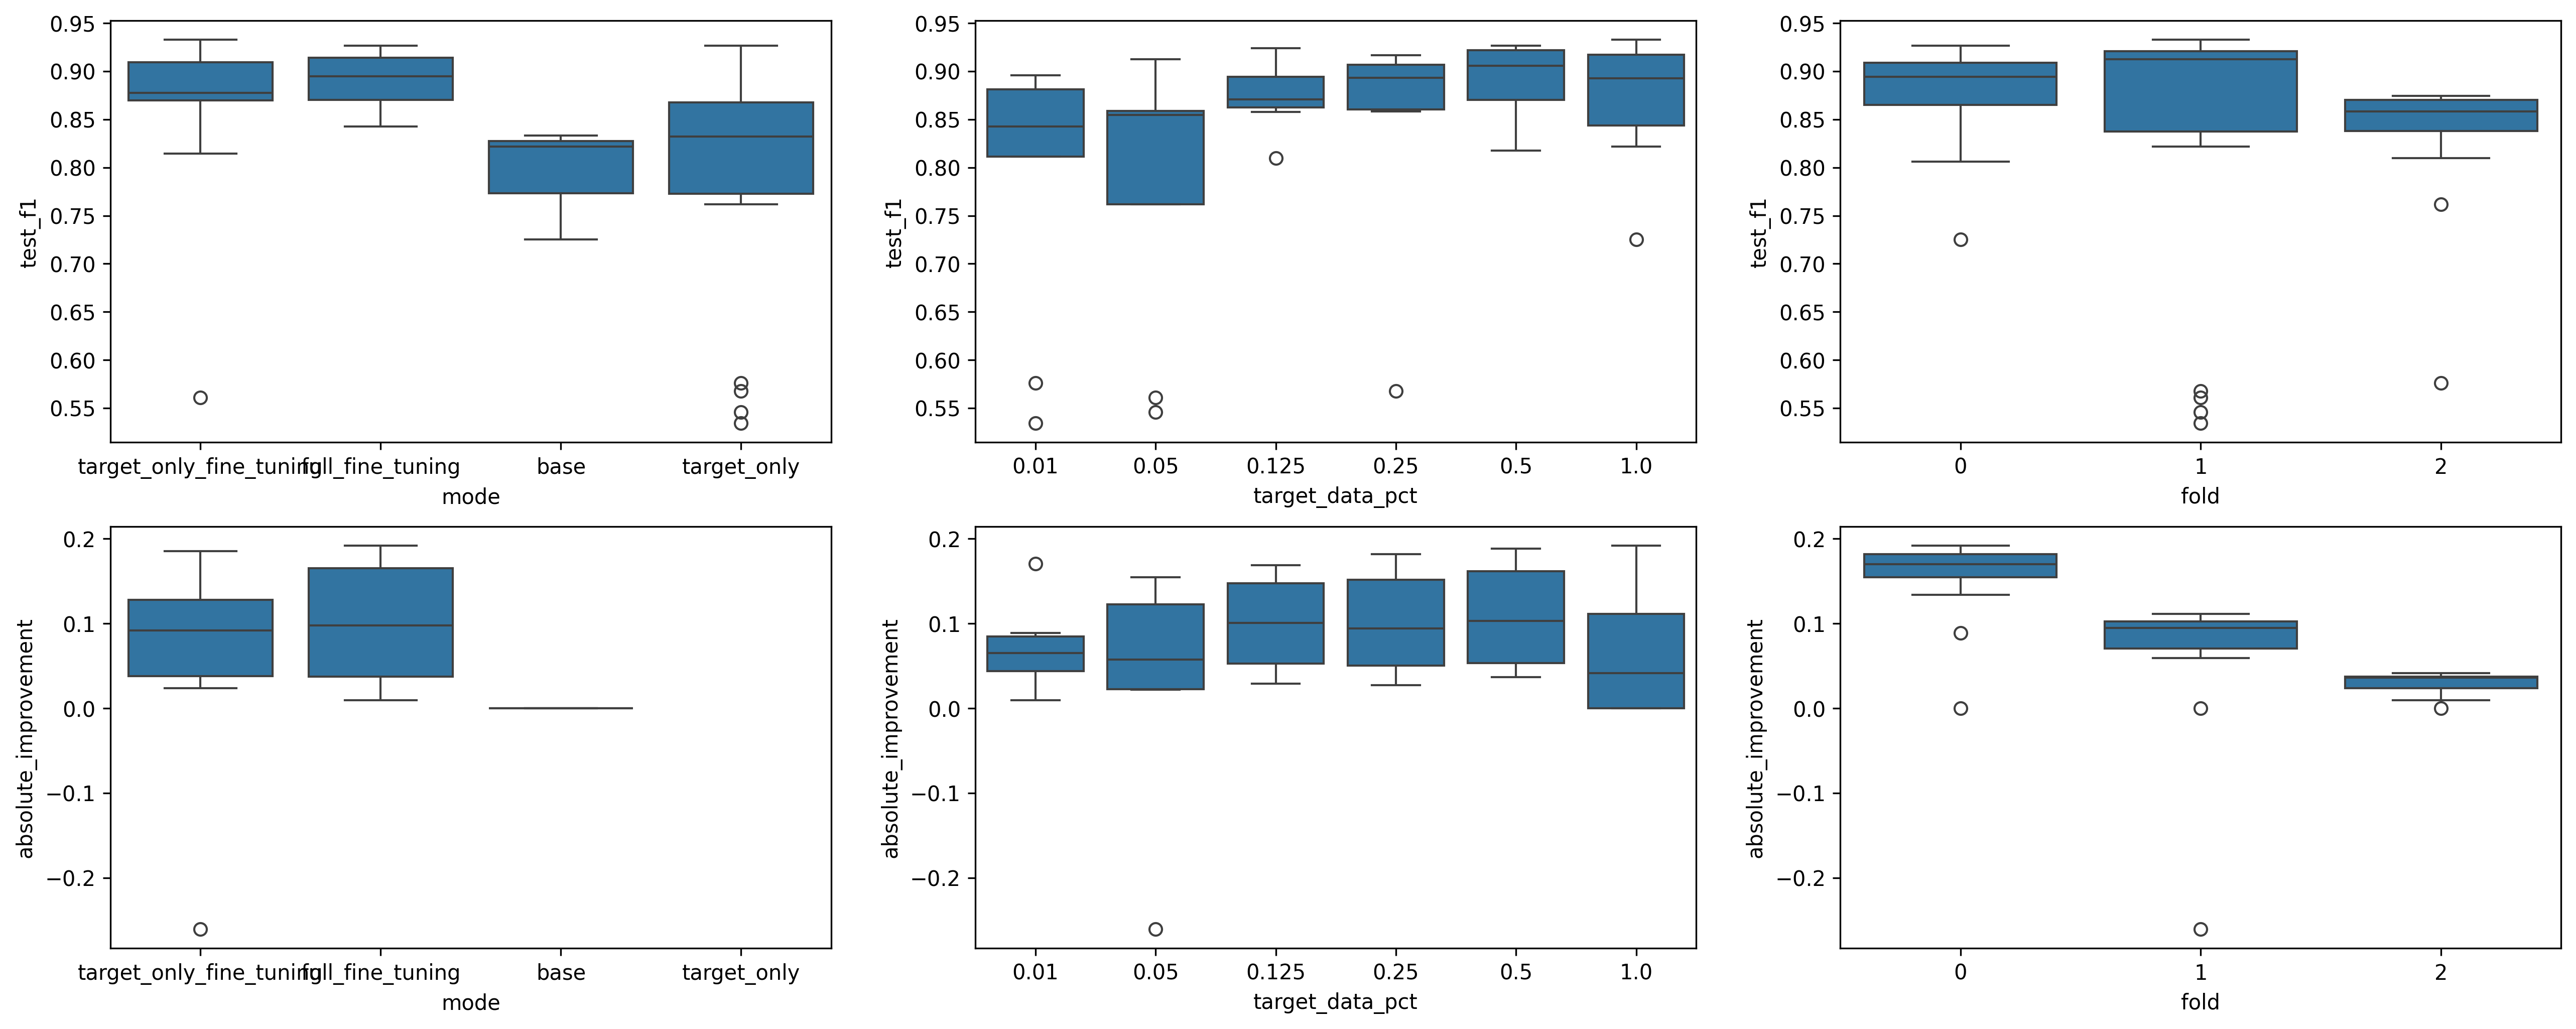

In [198]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(21, 8), dpi=300)

sns.boxplot(data=df, x='mode', y='test_f1', ax=ax[0,0])
sns.boxplot(data=df, x='target_data_pct', y='test_f1', ax=ax[0,1])
sns.boxplot(data=df, x='fold', y='test_f1', ax=ax[0,2])

sns.boxplot(data=df, x='mode', y='absolute_improvement', ax=ax[1,0])
sns.boxplot(data=df, x='target_data_pct', y='absolute_improvement', ax=ax[1,1])
sns.boxplot(data=df, x='fold', y='absolute_improvement', ax=ax[1,2])

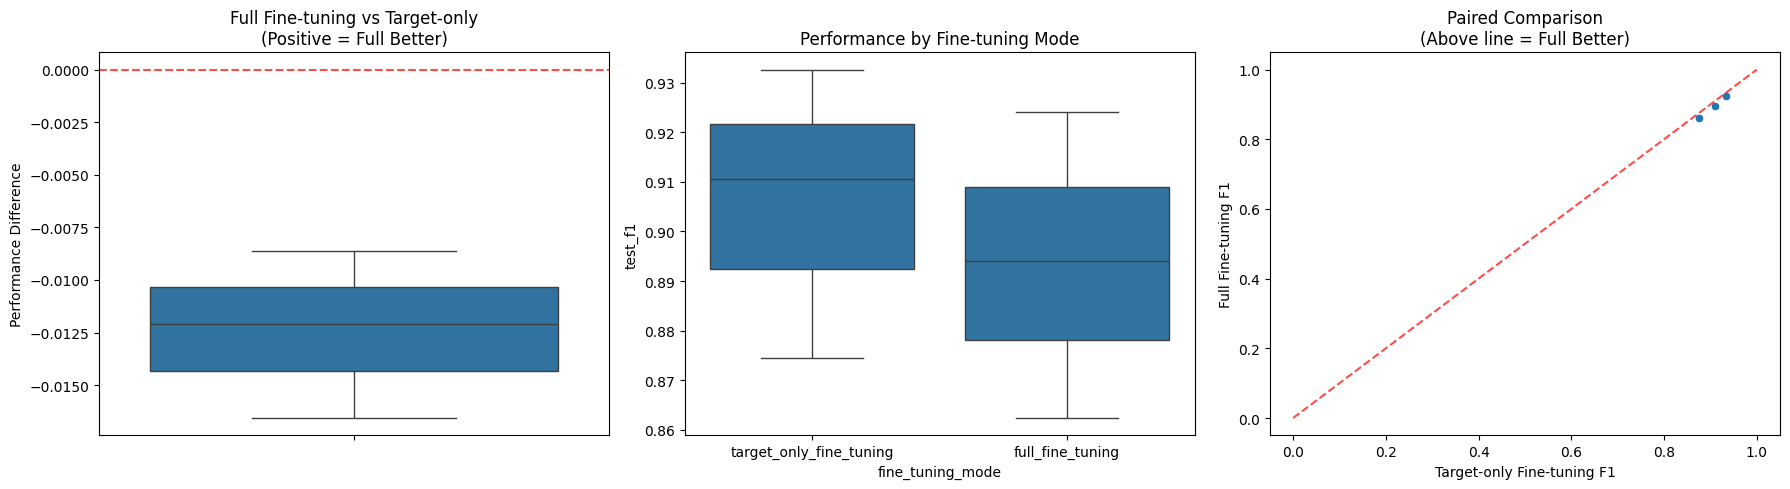

Summary of Fine-tuning Comparison:
Mean difference (Full - Target-only): -0.0124
Std of difference: 0.0040
Full fine-tuning better in 0 out of 3 cases


In [189]:
def get_base_test_f1(row):
    if row['mode'] == 'base':
        return row['test_f1']
    else:
        base_row = df[df['experiment'] == row['base_experiment_prefix']]
        return base_row['test_f1'].iloc[0] if len(base_row) > 0 else None

df['base_test_f1'] = df.apply(get_base_test_f1, axis=1)
df['absolute_improvement'] = df['test_f1'] - df['base_test_f1']

# Do similar for difference between target only fine tuning and full fine tuning paired by base experiment
# Create a function to get the performance for each fine-tuning mode
def get_finetune_comparison(df):
    # Filter to only fine-tuning experiments (not base)
    finetune_df = df[df['mode'].isin(['target_only_fine_tuning', 'full_fine_tuning'])].copy()
    
    # Pivot to get both modes side by side for each base experiment
    comparison_df = finetune_df.pivot_table(
        values='test_f1', 
        index=['base_experiment_prefix', 'fold'], 
        columns='mode', 
        aggfunc='first'
    ).reset_index()
    
    # Calculate the difference (full - target_only)
    comparison_df['full_vs_target_only_diff'] = (
        comparison_df['full_fine_tuning'] - comparison_df['target_only_fine_tuning']
    )
    
    return comparison_df

# Get the comparison
finetune_comparison = get_finetune_comparison(df)

# Add this back to the main dataframe
df = df.merge(
    finetune_comparison[['base_experiment_prefix', 'fold', 'full_vs_target_only_diff']], 
    on=['base_experiment_prefix', 'fold'], 
    how='left'
)

# Now you can visualize which approach is better
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Box plot of the difference
sns.boxplot(data=finetune_comparison, y='full_vs_target_only_diff', ax=axes[0])
axes[0].axhline(y=0, color='red', linestyle='--', alpha=0.7)
axes[0].set_title('Full Fine-tuning vs Target-only\n(Positive = Full Better)')
axes[0].set_ylabel('Performance Difference')

# Side-by-side comparison
finetune_melted = finetune_comparison.melt(
    id_vars=['base_experiment_prefix', 'fold'],
    value_vars=['target_only_fine_tuning', 'full_fine_tuning'],
    var_name='fine_tuning_mode',
    value_name='test_f1'
)
sns.boxplot(data=finetune_melted, x='fine_tuning_mode', y='test_f1', ax=axes[1])
axes[1].set_title('Performance by Fine-tuning Mode')

# Scatter plot showing paired comparison
sns.scatterplot(
    data=finetune_comparison, 
    x='target_only_fine_tuning', 
    y='full_fine_tuning',
    ax=axes[2]
)
axes[2].plot([0, 1], [0, 1], 'r--', alpha=0.7)  # Diagonal line
axes[2].set_title('Paired Comparison\n(Above line = Full Better)')
axes[2].set_xlabel('Target-only Fine-tuning F1')
axes[2].set_ylabel('Full Fine-tuning F1')

plt.tight_layout()
plt.show()

# Print summary statistics
print("Summary of Fine-tuning Comparison:")
print(f"Mean difference (Full - Target-only): {finetune_comparison['full_vs_target_only_diff'].mean():.4f}")
print(f"Std of difference: {finetune_comparison['full_vs_target_only_diff'].std():.4f}")
print(f"Full fine-tuning better in {(finetune_comparison['full_vs_target_only_diff'] > 0).sum()} out of {len(finetune_comparison)} cases")

<Axes: xlabel='mode', ylabel='test_f1'>

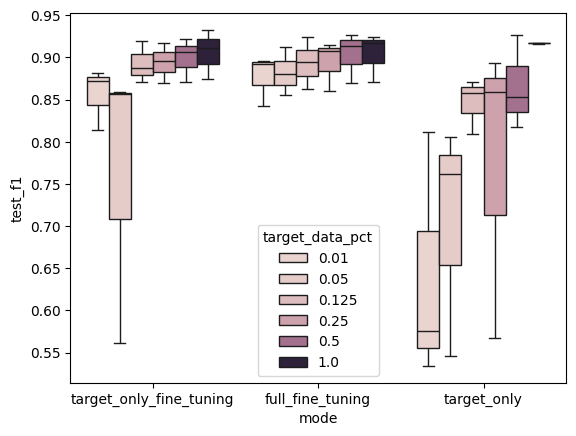

In [195]:
df_plot = df.copy()
df = df[df['mode'] != 'base']  # Exclude base for this plot because it has no target_data_pct
sns.boxplot(data=df, x='mode', y='test_f1', hue='target_data_pct')

In [ ]:
        metrics = json.load(open(f'{experiments_dir}/{experiment}/{run}/metrics.json'))
        losses = json.load(open(f'{experiments_dir}/{experiment}/{run}/losses.json'))
        hyperparameters = json.load(open(f'{experiments_dir}/{experiment}/{run}/hyperparameters.json'))

        data.append({
            'hyperparameter_hash': experiment.split('_')[-1],
            'batch_size': hyperparameters['batch_size'], 
            'fold': int(run.split('_')[0].replace('fold','')), 
            'target_data_pct': float(hyperparameters['target_data_pct']), 
            'n_base_participants': int(hyperparameters['n_base_participants']),
            'mode': hyperparameters['mode'],
            'best_target_model_target_val_f1': metrics['best_target_model_target_val_f1'], 
            'best_target_model_target_test_f1': metrics['best_target_model_target_test_f1'],
            'best_base_model_target_val_f1': metrics['best_base_model_target_val_f1'] if 'best_base_model_target_val_f1' in metrics else None,
            'best_base_model_target_test_f1': metrics['best_base_model_target_test_f1'] if 'best_base_model_target_test_f1' in metrics else None,
            'best_target_model_target_val_loss': metrics['best_target_model_target_val_loss'] if 'best_target_model_target_val_loss' in metrics else None,
            'best_target_model_target_test_loss': metrics['best_target_model_target_test_loss'] if 'best_target_model_target_test_loss' in metrics else None,
            'best_base_model_target_val_loss': metrics['best_base_model_target_val_loss'] if 'best_base_model_target_val_loss' in metrics else None,
            'best_base_model_target_test_loss': metrics['best_base_model_target_test_loss'] if 'best_base_model_target_test_loss' in metrics else None,
            'absolute_improvement_target_test_f1': (metrics['best_target_model_target_test_f1'] - metrics['best_base_model_target_test_f1']) if 'best_base_model_target_test_f1' in metrics else None,
            'absolute_improvement_target_val_f1': (metrics['best_target_model_target_val_f1'] - metrics['best_base_model_target_val_f1']) if 'best_base_model_target_val_f1' in metrics else None,
        })
        

In [69]:
print(df['hyperparameter_hash'].value_counts())
print(df['mode'].value_counts())
print(df['target_data_pct'].value_counts())
print(df['batch_size'].value_counts())
print(df['n_base_participants'].value_counts())

hyperparameter_hash
709c76b9    7
0e69ae49    7
22bcfae0    7
f967fcfc    7
48c246f6    7
           ..
90335249    6
add877ac    6
134236      6
ae662971    6
946bcc12    1
Name: count, Length: 188, dtype: int64
mode
target_only                517
full_fine_tuning           502
target_only_fine_tuning    287
Name: count, dtype: int64
target_data_pct
0.010    245
1.000    222
0.050    210
0.125    210
0.250    210
0.500    209
Name: count, dtype: int64
batch_size
32    754
64    552
Name: count, dtype: int64
n_base_participants
1    230
2    217
3    217
5    216
4    216
6    210
Name: count, dtype: int64


<Axes: xlabel='fold', ylabel='best_target_model_target_val_f1'>

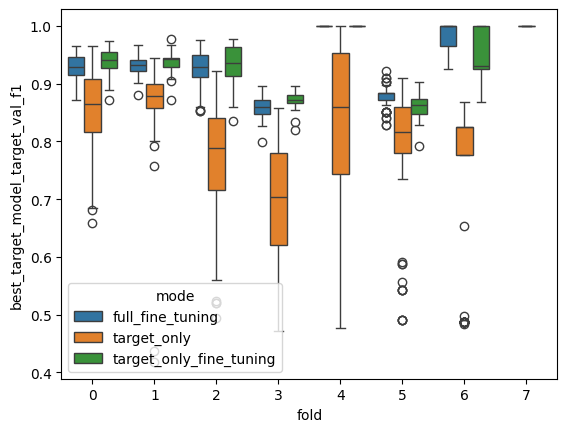

In [21]:
df_plot = df.copy()
sns.boxplot(data=df_plot, x='fold', y='best_target_model_target_val_f1', hue='mode')

<Axes: xlabel='metric', ylabel='value'>

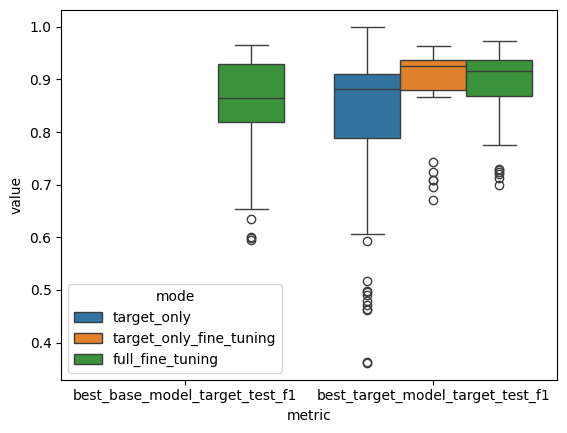

In [ ]:
df_plot = df.copy()
# df_plot = df_plot[df_plot['mode'] == 'full_fine_tuning']
df_plot = df_plot[df_plot['target_data_pct'] == 1]
# df_plot = df_plot[df_plot['n_base_participants'] == 6]
df_plot = df_plot.melt(value_vars=['best_base_model_target_test_f1','best_target_model_target_test_f1'],id_vars=['fold','batch_size','target_data_pct','n_base_participants','mode'], var_name='metric', value_name='value')
sns.boxplot(data=df_plot, x='metric', y='value', hue='mode')

<Axes: xlabel='fold', ylabel='value'>

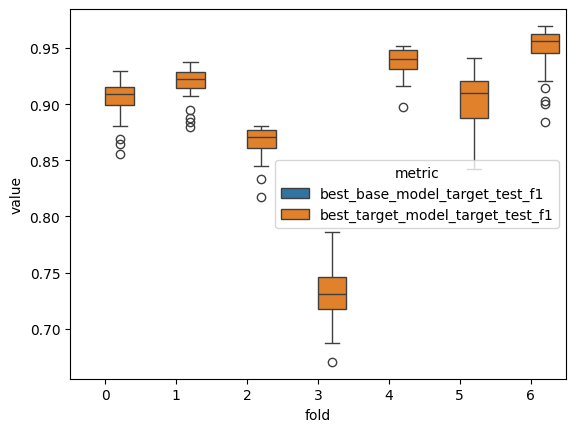

In [ ]:
df_plot = df.copy()
df_plot = df_plot[df_plot['mode'] == 'target_only_fine_tuning']
# df_plot = df_plot[df_plot['target_data_pct'] == 1]
# df_plot = df_plot[df_plot['n_base_participants'] == 6]
df_plot = df_plot.melt(value_vars=['best_base_model_target_test_f1','best_target_model_target_test_f1'],id_vars=['fold','batch_size','target_data_pct','n_base_participants','mode'], var_name='metric', value_name='value')
df_plot
sns.boxplot(data=df_plot, x='fold', y='value', hue='metric')

<Axes: xlabel='fold', ylabel='value'>

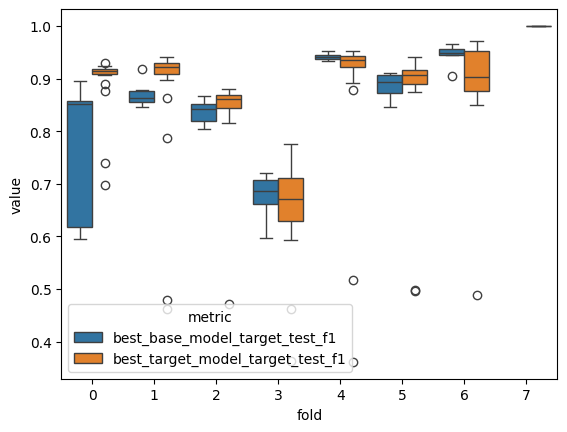

<Axes: xlabel='mode', ylabel='best_target_model_target_test_f1'>

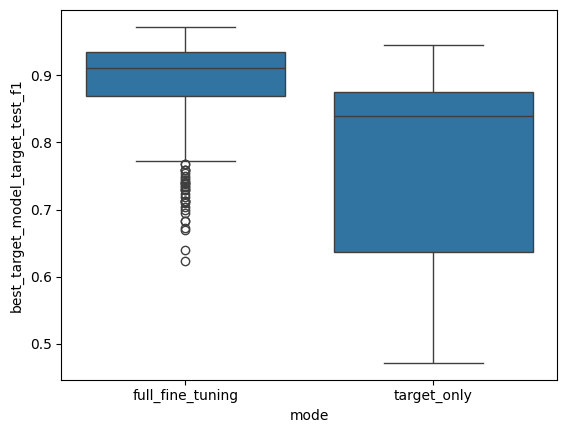

In [6]:
sns.boxplot(data=df, x='mode', y='best_target_model_target_test_f1')

<Axes: xlabel='mode', ylabel='best_target_model_target_test_f1'>

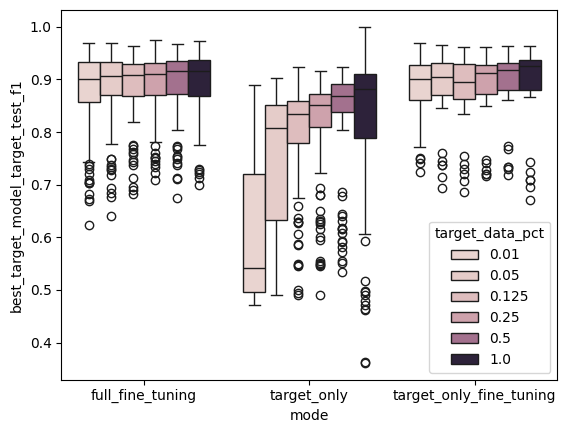

In [22]:
sns.boxplot(data=df, x='mode', y='best_target_model_target_test_f1', hue='target_data_pct')

<Axes: xlabel='batch_size', ylabel='best_target_model_target_val_loss'>

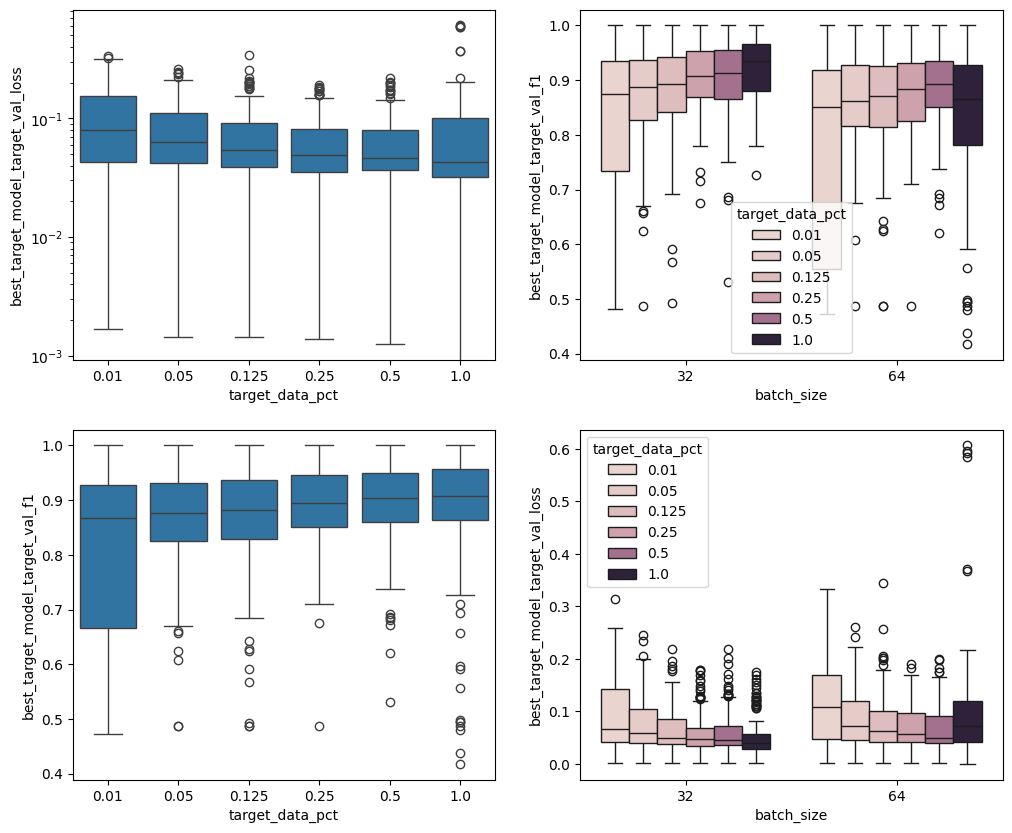

In [23]:
fig,ax = plt.subplots(2,2, figsize=(12,10))
sns.boxplot(data=df, x='target_data_pct', y='best_target_model_target_val_loss', ax=ax[0,0])
ax[0,0].set_yscale('log')
sns.boxplot(data=df, x='target_data_pct', y='best_target_model_target_val_f1', ax=ax[1,0])
sns.boxplot(data=df, x='batch_size', y='best_target_model_target_val_f1', hue='target_data_pct', ax=ax[0,1])
sns.boxplot(data=df, x='batch_size', y='best_target_model_target_val_loss', hue='target_data_pct', ax=ax[1,1])

<Axes: xlabel='n_base_participants', ylabel='best_target_model_target_test_f1'>

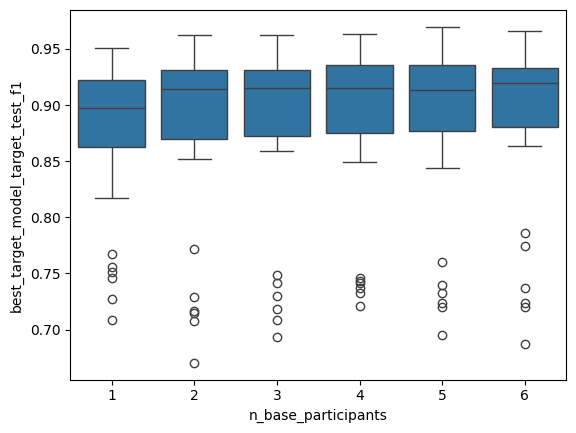

In [25]:
df_plot = df.copy()
df_plot = df_plot[df_plot['mode'] == 'target_only_fine_tuning']
# df_plot = df_plot[df_plot['target_data_pct'] == 1]
sns.boxplot(data=df_plot, x='n_base_participants', y='best_target_model_target_test_f1')

In [71]:
best_model_hash = df.groupby('hyperparameter_hash')['best_target_model_target_val_f1'].mean().sort_values(ascending=False).keys()[0]
print(best_model_hash)
df_metrics = df[df['hyperparameter_hash'] == best_model_hash].copy()
# Compute Metrics For Paper
display(df_metrics)
df_metrics = df_metrics[['fold','best_base_model_target_test_f1','best_target_model_target_test_f1']]
df_metrics.sort_values('fold', inplace=True)
# Add Absolute Improvement
df_metrics['absolute_improvement'] = df_metrics['best_target_model_target_test_f1'] - df_metrics['best_base_model_target_test_f1']
# Add Relative Improvement
df_metrics['relative_improvement'] = df_metrics['absolute_improvement'] / df_metrics['best_base_model_target_test_f1']
# Add Room For Improvement Metric
df_metrics['room_for_improvement'] = (1 - df_metrics['best_base_model_target_test_f1'])
df_metrics['room_for_improvement_pct'] = df_metrics['absolute_improvement'] / df_metrics['room_for_improvement']

61c4dfba


,hyperparameter_hash,batch_size,fold,target_data_pct,n_base_participants,mode,best_target_model_target_val_f1,best_target_model_target_test_f1,best_base_model_target_val_f1,best_base_model_target_test_f1,best_target_model_target_val_loss,best_target_model_target_test_loss,best_base_model_target_val_loss,best_base_model_target_test_loss,absolute_improvement_target_test_f1,absolute_improvement_target_val_f1
368,61c4dfba,64,4,1.0,4,full_fine_tuning,1.000000,0.943886,0.953176,0.954331,0.002499,0.016863,0.007558,0.015653,-0.010445,0.046824
369,61c4dfba,64,1,1.0,4,full_fine_tuning,0.954304,0.925090,0.885282,0.872096,0.034892,0.047301,0.070219,0.070918,0.052994,0.069022
370,61c4dfba,64,3,1.0,4,full_fine_tuning,0.879907,0.768447,0.847280,0.757142,0.129341,0.097208,0.161633,0.108018,0.011305,0.032627
371,61c4dfba,64,6,1.0,4,full_fine_tuning,1.000000,0.965755,0.925346,0.962855,0.005640,0.019101,0.025717,0.022802,0.002900,0.074654
372,61c4dfba,64,5,1.0,4,full_fine_tuning,0.913954,0.896523,0.791364,0.911271,0.033884,0.039376,0.046610,0.029560,-0.014749,0.122591
373,61c4dfba,64,0,1.0,4,full_fine_tuning,0.954669,0.912278,0.864929,0.852632,0.048899,0.062498,0.083237,0.093617,0.059646,0.089740
374,61c4dfba,64,2,1.0,4,full_fine_tuning,0.951994,0.874950,0.938676,0.854556,0.038804,0.072560,0.044573,0.075249,0.020395,0.013319


Loading model from b64_t0.25_20251001_201839_d3fb8769
Runs: ['fold4_ejaz', 'fold1_asfik', 'fold3_anam', 'fold6_unk1', 'fold5_iftakhar', 'fold0_tonmoy', 'fold2_alsaad']
Loading model from fold4_ejaz
Loading data from data/001_60s_window for target participant ejaz
Target train dataset size: 4112
Subsampling dataset to 25.0% of original size
Target train dataset size: 1028
Target val dataset size: 1887
Subsampling dataset to 10.0% of original size
Target val dataset size: 188
Loading base model from ./experiments/b64_t0.25_20251001_201839_d3fb8769/fold4_ejaz/best_base_model.pt
              precision    recall  f1-score   support

  No Smoking       1.00      1.00      1.00      6047
     Smoking       0.94      0.84      0.89       162

    accuracy                           0.99      6209
   macro avg       0.97      0.92      0.94      6209
weighted avg       0.99      0.99      0.99      6209

Loading model from fold1_asfik
Loading data from data/001_60s_window for target participant

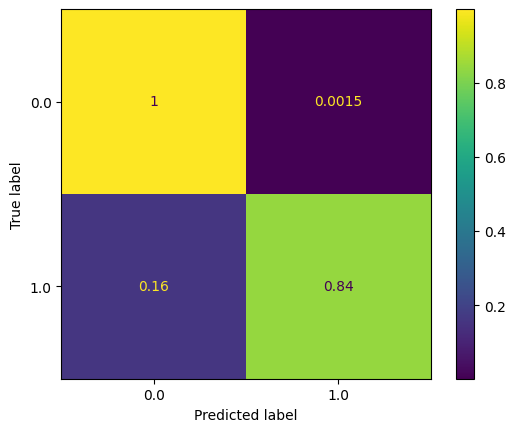

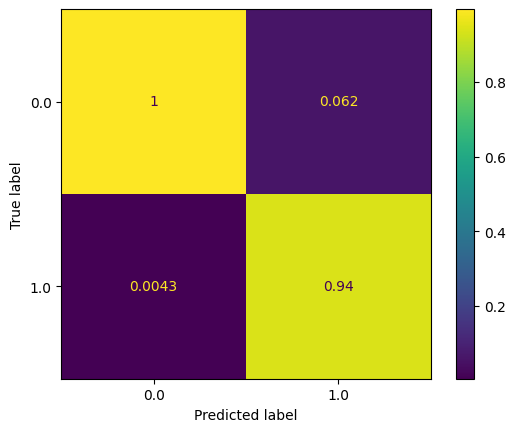

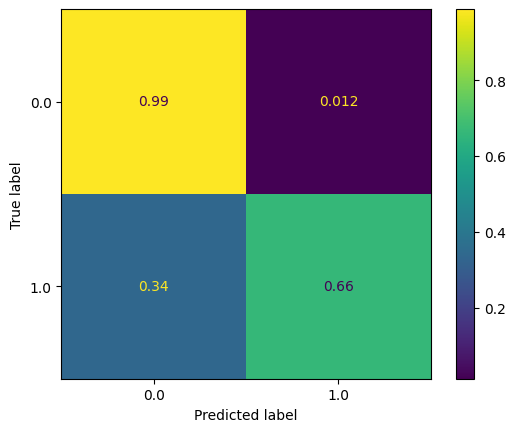

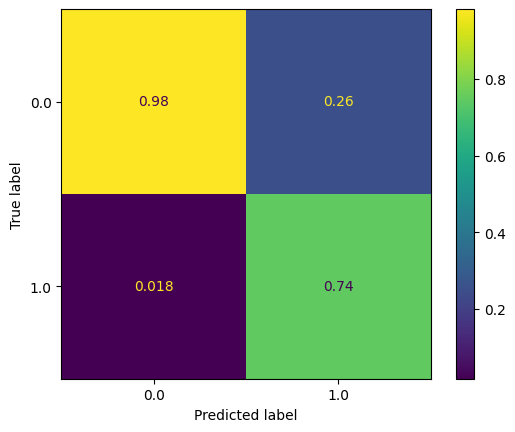

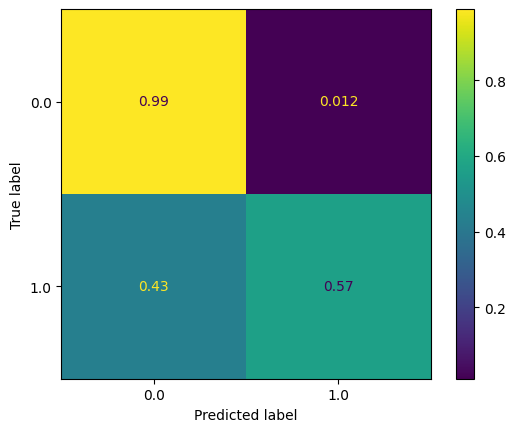

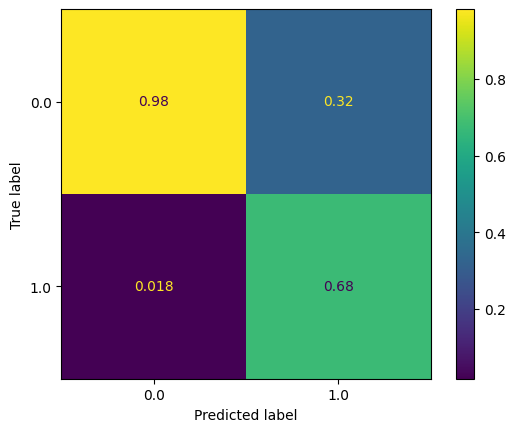

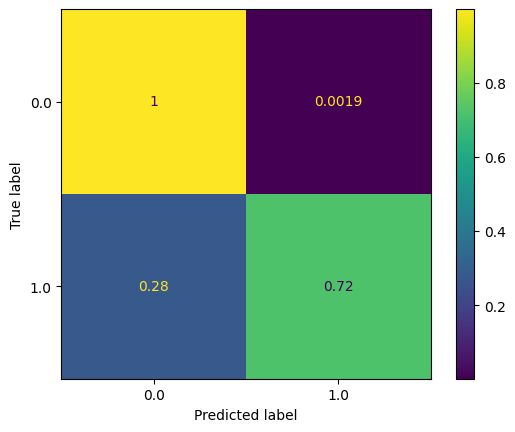

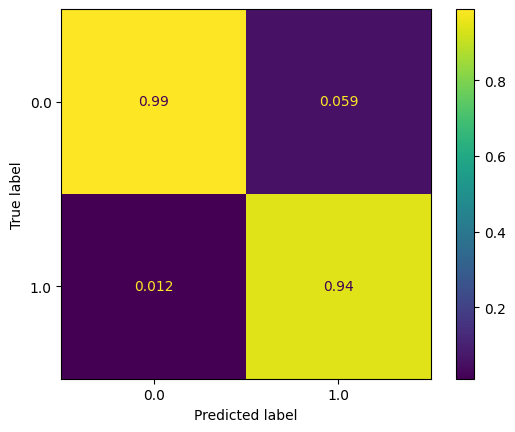

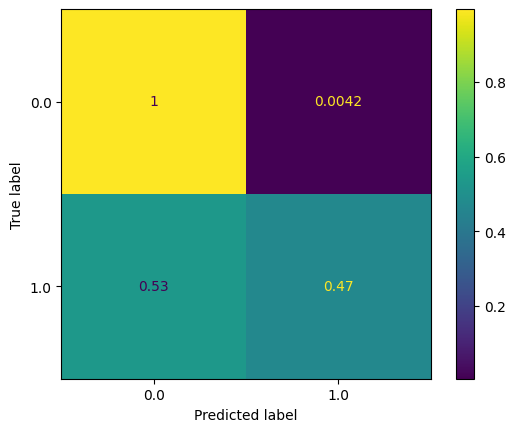

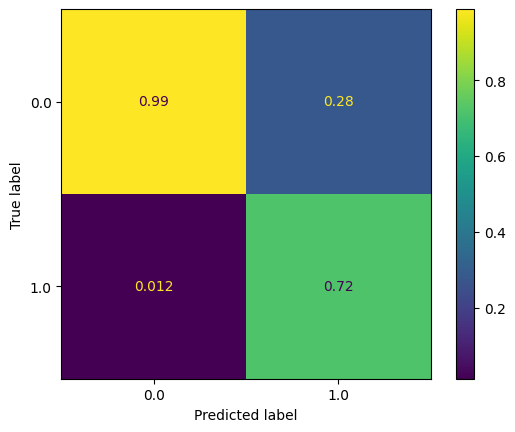

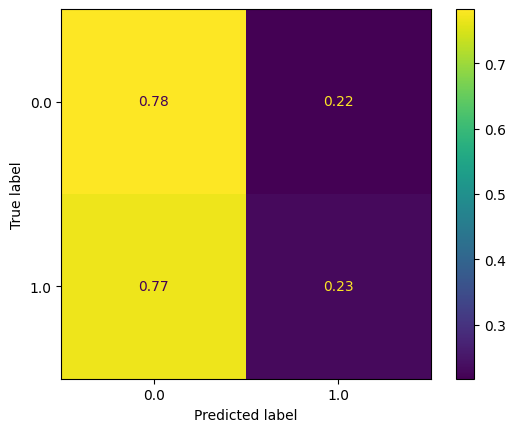

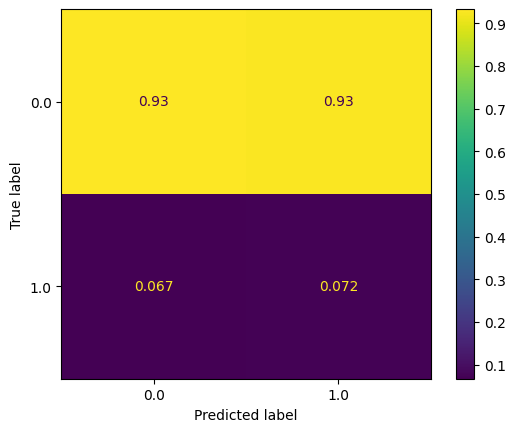

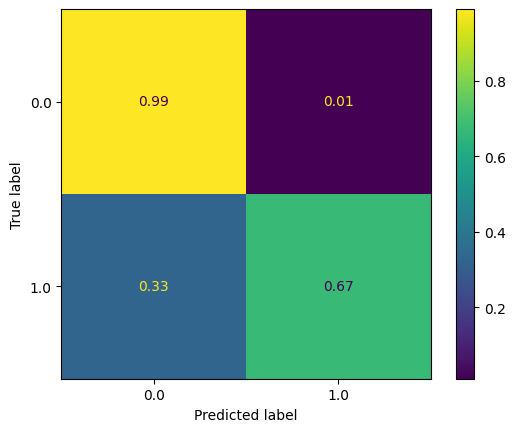

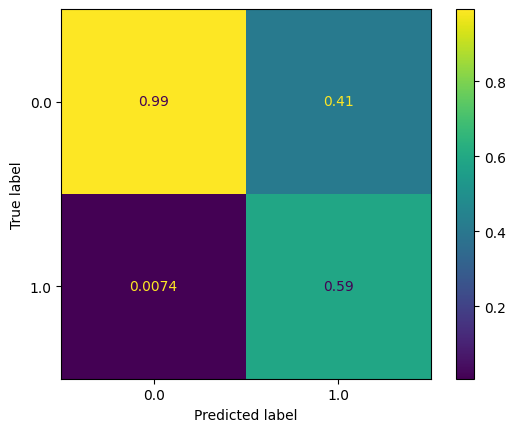

In [65]:
from lib.models import TestModel
from lib.train_utils import compute_loss_and_f1,evaluate
from sklearn.metrics import classification_report
from lib.train_utils import random_subsample
device = 'cpu'

# Load Model From Best Model Hash
# You can change this to load a different model if you want to inspect it
best_model_dir = [d for d in os.listdir(experiments_dir) if best_model_hash in d][0]
print(f'Loading model from {best_model_dir}')

run_dirs = os.listdir(f'{experiments_dir}/{best_model_dir}')
print(f'Runs: {run_dirs}')

df_metrics['best_target_model_target_test_precision'] = 0.0
df_metrics['best_target_model_target_test_recall'] = 0.0

for run_dir in run_dirs:
    print(f'Loading model from {run_dir}')
    best_base_model_path = f'{experiments_dir}/{best_model_dir}/{run_dir}/best_base_model.pt'

    criterion = nn.BCEWithLogitsLoss()
    hyperparameters = json.load(open(f'{experiments_dir}/{best_model_dir}/{run_dir}/hyperparameters.json'))
    target_participant = hyperparameters['target_participant']
    data_path = hyperparameters['data_path']
    batch_size = hyperparameters['batch_size']
    fold = hyperparameters['fold']
    print(f'Loading data from {data_path} for target participant {target_participant}')
    target_train_dataset = TensorDataset(*torch.load(f'{data_path}/{target_participant}_train.pt'))
    target_val_dataset = TensorDataset(*torch.load(f'{data_path}/{target_participant}_val.pt'))
    target_test_dataset = TensorDataset(*torch.load(f'{data_path}/{target_participant}_test.pt'))

    # Subsample target training data if specified
    target_data_pct = hyperparameters['target_data_pct']
    if target_data_pct < 1.0:
        print(f'Target train dataset size: {len(target_train_dataset)}')
        target_train_dataset = random_subsample(target_train_dataset, target_data_pct)
        print(f'Target train dataset size: {len(target_train_dataset)}')

    print(f'Target val dataset size: {len(target_val_dataset)}')
    target_val_dataset = random_subsample(target_val_dataset, .1)
    print(f'Target val dataset size: {len(target_val_dataset)}')

    target_trainloader = DataLoader(target_train_dataset, batch_size=batch_size, shuffle=True)
    target_valloader = DataLoader(target_val_dataset, batch_size=batch_size, shuffle=False)
    target_testloader = DataLoader(target_test_dataset, batch_size=batch_size, shuffle=False)

    model = TestModel()
    print(f'Loading base model from {best_base_model_path}')
    model.load_state_dict(torch.load(best_base_model_path, map_location='cpu'))
    model.to(device)

    test_loss, test_f1 = compute_loss_and_f1(model, target_testloader, criterion, device=device)
    y_true,y_pred = evaluate(model, target_testloader, device=device)

    report = classification_report(y_true, y_pred, output_dict=True)
    precision = report['macro avg']['precision']
    recall = report['macro avg']['recall']

    df_metrics.loc[df_metrics['fold'] == fold,'best_target_model_target_test_precision'] = precision
    df_metrics.loc[df_metrics['fold'] == fold,'best_target_model_target_test_recall'] = recall

,fold,best_base_model_target_test_f1,best_target_model_target_test_f1,absolute_improvement,relative_improvement,room_for_improvement,room_for_improvement_pct,best_target_model_target_test_precision,best_target_model_target_test_recall
472,0.000000,NaN,0.921797,NaN,NaN,NaN,NaN,0.982920,0.815804
468,1.000000,NaN,0.927673,NaN,NaN,NaN,NaN,0.960699,0.858672
473,2.000000,NaN,0.873128,NaN,NaN,NaN,NaN,0.821031,0.921685
469,3.000000,NaN,0.720257,NaN,NaN,NaN,NaN,0.765096,0.634663
467,4.000000,NaN,0.933365,NaN,NaN,NaN,NaN,0.973381,0.919174
471,5.000000,NaN,0.918082,NaN,NaN,NaN,NaN,0.958837,0.868746
470,6.000000,NaN,0.959528,NaN,NaN,NaN,NaN,0.997385,0.938202
median,3.000000,NaN,0.921797,NaN,NaN,NaN,NaN,0.960699,0.868746
mean,3.000000,NaN,0.896953,NaN,NaN,NaN,NaN,0.927506,0.853212
std,1.870829,NaN,0.070405,NaN,NaN,NaN,NaN,0.079810,0.090787


,fold,metric,value
0,0.0,best_base_model_target_test_f1,NaN
1,1.0,best_base_model_target_test_f1,NaN
2,2.0,best_base_model_target_test_f1,NaN
3,3.0,best_base_model_target_test_f1,NaN
4,4.0,best_base_model_target_test_f1,NaN
5,5.0,best_base_model_target_test_f1,NaN
6,6.0,best_base_model_target_test_f1,NaN
7,0.0,best_target_model_target_test_f1,0.921797
8,1.0,best_target_model_target_test_f1,0.927673
9,2.0,best_target_model_target_test_f1,0.873128


<Axes: xlabel='fold', ylabel='value'>

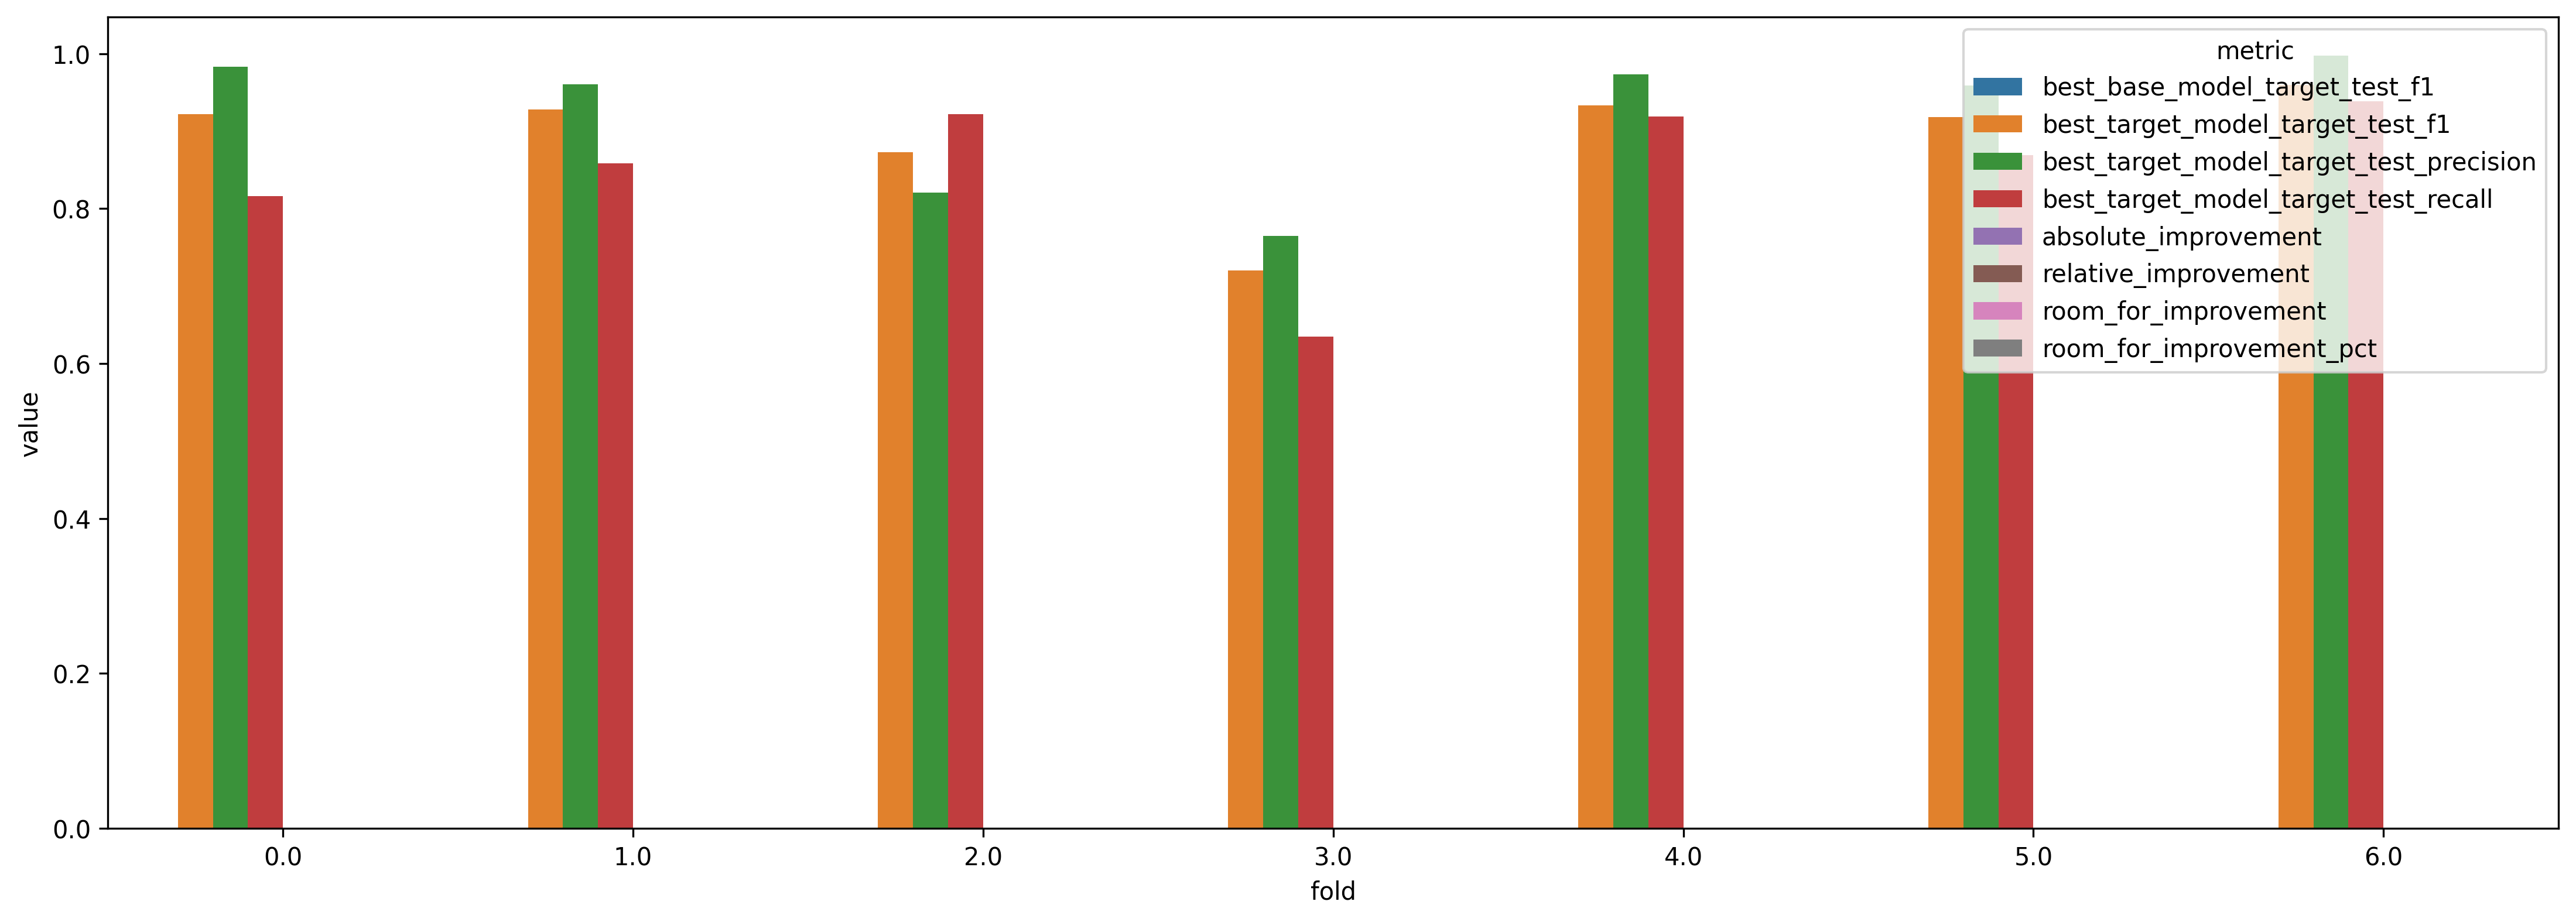

100%|██████████| 107/107 [00:00<00:00, 379.11it/s]


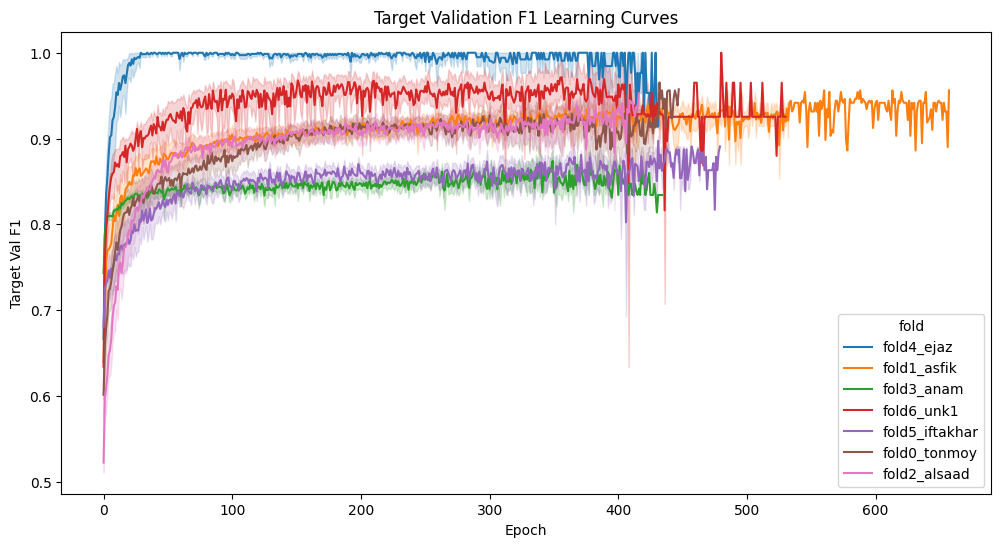

In [ ]:
# Target val f1 learning curves
curve_data = []
for experiment in tqdm(os.listdir(experiments_dir)):
    for run in os.listdir(f'{experiments_dir}/{experiment}'):
        if not os.path.exists(f'{experiments_dir}/{experiment}/{run}/losses.json'):
            continue
        losses = json.load(open(f'{experiments_dir}/{experiment}/{run}/losses.json'))
        hyperparameters = json.load(open(f'{experiments_dir}/{experiment}/{run}/hyperparameters.json'))

        if hyperparameters['mode'] != 'full_fine_tuning':
            continue
        
        for epoch, f1 in enumerate(losses['target val f1']):
            curve_data.append({
                'epoch': epoch,
                'target_val_f1': f1,
                'fold': run
            })

curve_df = pd.DataFrame(curve_data)
plt.figure(figsize=(12, 6))
sns.lineplot(data=curve_df, x='epoch', y='target_val_f1', hue='fold')
plt.title('Target Validation F1 Learning Curves')
plt.xlabel('Epoch')
plt.ylabel('Target Val F1')
plt.show()